<a href="https://colab.research.google.com/github/ClementBM/Experiment_DeepLearning_Moonboard_Grade-Prediction/blob/master/LSTM_BoulderProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import some relevant packages

In [1]:
from sklearn.utils import shuffle
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

from climbing_ai.moonboard_dataset import (MoonboardDataset, 
                                           data_preprocessing,
                                           extract_batch,
                                           data_2016_preprocessing)
from climbing_ai.moonboard_tokenizer import MoonboardTokenizer
from climbing_ai.moonboard_evaluation import evaluate, plot_confusion_matrix, predict, calculate_metrics
from climbing_ai.wolfbert_simple import WolfBERT

N_LAYERS = 3
ATTN_HEADS = 6 # 32 * 4 = 128
DROPOUT = 0.1
EMBED_DIM = 60

IGNORE_INDEX = -100

EVAL_ITERS = 10
MAX_ITERS = 10000
EVAL_INTERVAL = 1000
LEARNING_RATE = 1e-4
EPOCHS = 600

BATCH_SIZE = 64 # how many independent sequences will we process in parallel?

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define tokenizer

In [2]:
tokenizer = MoonboardTokenizer(
    horizontal_count=11,
    vertical_count=18,
    horizontal_spacing=50,
    vertical_spacing=50,
)

# Load and parse data

In [3]:
# dataset = data_preprocessing()
dataset = data_2016_preprocessing(tokenizer)

shuffled_dataset = shuffle(dataset, random_state=42)

# Keep 90% for training, 10% for validation
split = int(0.9 * len(dataset))

train_ds = shuffled_dataset[:split]
eval_ds = shuffled_dataset[split:]

all_dataset = MoonboardDataset(dataset=dataset, tokenizer=tokenizer)
selected_grades = [k for k, v in all_dataset.grade_freq.items() if v > 30]

train_dataset = MoonboardDataset(dataset=train_ds, tokenizer=tokenizer, 
                                 max_len=all_dataset.max_len, selected_grades=selected_grades)

eval_dataset = MoonboardDataset(dataset=eval_ds, tokenizer=tokenizer, 
                                max_len=all_dataset.max_len, selected_grades=selected_grades)


train_dataset.filter_by_grade(selected_grades)
eval_dataset.filter_by_grade(selected_grades)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=True)

# Building the model

In [4]:
model = WolfBERT(
    vocab_size=tokenizer.get_vocab_size(),
    embed_dim=EMBED_DIM,
    num_heads=ATTN_HEADS,
    dropout=DROPOUT,
    classifier_count=len(selected_grades)
)
m = model.to(DEVICE)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# `ignore_index`: specifies a target value that is ignored
# and does not contribute to the input gradient. When :attr:`size_average` is
# `True`, the loss is averaged over non-ignored targets. Note that
# Only applicable when the target contains class indices

loss_fn_lm = torch.nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
loss_fn_clsf = torch.nn.CrossEntropyLoss() 

# Training loop

In [5]:
epoch_iterator = tqdm(range(1))
model.train()

for epoch in epoch_iterator:
    for batch in train_dataloader:
        (
            input_ids,
            input_locations,
            masked_input_ids,
            masked_token_ids,
            masked_positions,
            attention_mask,
            grade_id,
            sequence_length,
        ) = extract_batch(batch, DEVICE)

        # evaluate the loss
        logits_lm, logits_clsf = model(masked_input_ids,
                                       attention_mask,
                                       masked_positions)
        
        loss_lm = loss_fn_lm(logits_lm.transpose(-2,-1), masked_token_ids) # for masked LM
        loss_clsf = loss_fn_clsf(logits_clsf, grade_id) # for sentence classification
        loss = loss_lm + loss_clsf
        
        epoch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 1/1 [00:07<00:00,  7.70s/it, loss=6.692]


# Test time

In [6]:
from random import randint


test_batch = train_dataset[randint(0,100)]

input_ids = test_batch['input_ids'].unsqueeze(0).to(DEVICE)
input_locations = test_batch['input_locations'].unsqueeze(0).to(DEVICE)
masked_input_ids = test_batch['masked_input_ids'].unsqueeze(0).to(DEVICE)
masked_token_ids = test_batch['masked_token_ids'].unsqueeze(0).to(DEVICE)
masked_positions = test_batch['masked_positions'].unsqueeze(0).to(DEVICE)
attention_mask = test_batch['attention_mask'].unsqueeze(0).to(DEVICE)

model.eval()
logits_lm, logits_clsf = model(masked_input_ids,
                               attention_mask,
                               masked_positions)
model.train()

print(tokenizer.decode(masked_input_ids.cpu().squeeze().numpy()))
print(tokenizer.decode(input_ids.cpu().squeeze().numpy()))

display(tokenizer.decode(torch.argmax(logits_lm[0], dim=1).cpu().squeeze().numpy())[0])

display(torch.argmax(logits_clsf))
display(test_batch["grade_id"])

['[CLS]', 'A18', 'B9', 'B13', 'J8', 'E13', 'F12', 'G2', 'G6', 'I4', '[MASK]', '[EOB]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'A18', 'B9', 'B13', 'D17', 'E13', 'F12', 'G2', 'G6', 'I4', 'I10', '[EOB]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


'G2'

tensor(0, device='cuda:0')

tensor(4)

# Evaluate
* We make predictions on the test set rounding the predicted grade floating number.
* We then calculate the related MAE based on these prediction.
* The grade error is shown in the heat map.
* The absolute error is shown in the histogram.

In [8]:
def call_model(compressed_batch, model):
    (
        input_ids,
        input_locations,
        masked_input_ids,
        masked_token_ids,
        masked_positions,
        attention_mask,
        grade_id,
        sequence_length,
    ) = compressed_batch

    logits_lm, logits_clsf = model(
        masked_input_ids,
        attention_mask,
        masked_positions
    )
    return logits_clsf

predictions, truths, probabilities = predict(model=model,
         call_model=call_model,
         dataloader=eval_dataloader,
         device=DEVICE)

In [9]:
calculate_metrics(truths, predictions, probabilities)

ROC AUC: 0.557509
Accuracy: 0.334205
Precision: 0.111693


/home/clem/Source/climbing-moonboard-ai/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.334205
F1 score: 0.167430


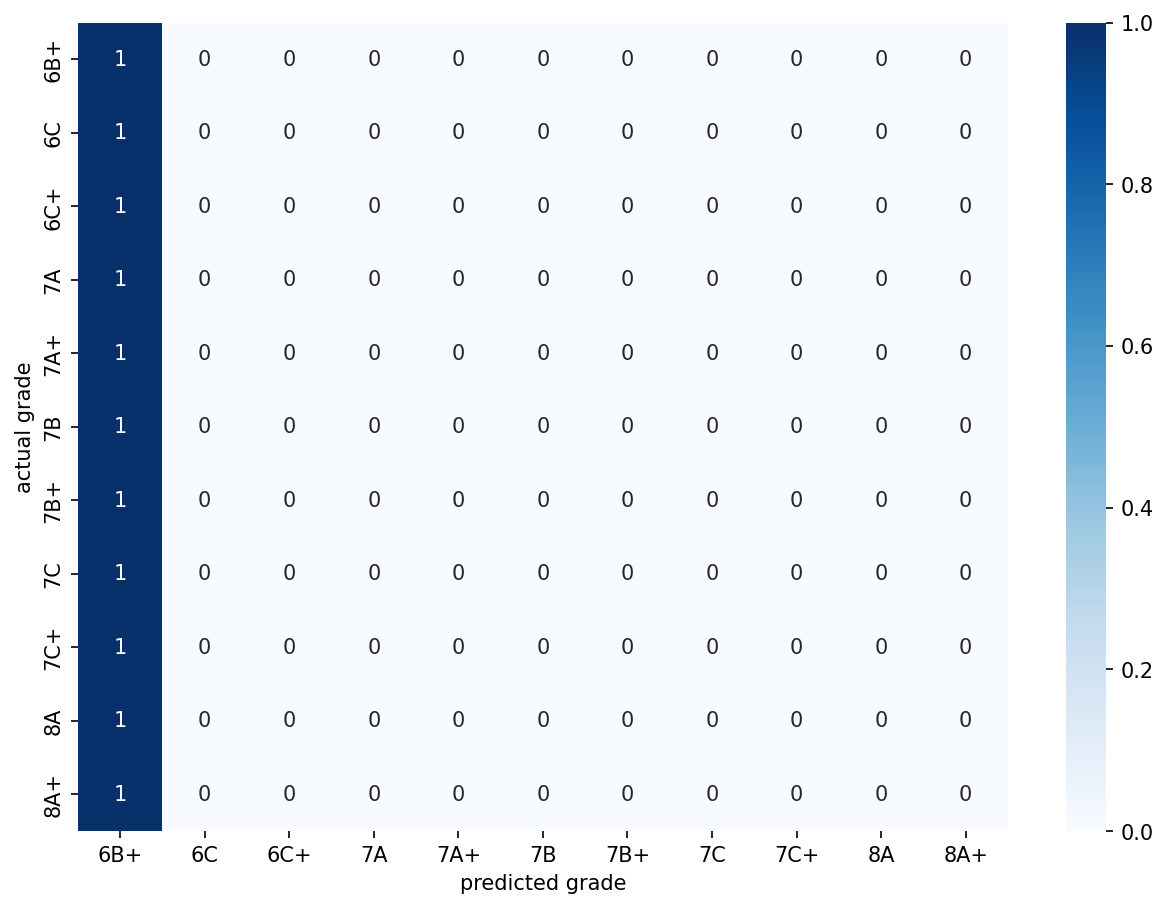

In [10]:
plot_confusion_matrix(truths, predictions, selected_grades)

/home/clem/Source/climbing-moonboard-ai/climbing_ai/moonboard_evaluation.py:110: RuntimeWarning: invalid value encountered in divide
  errorByGradeNorm = error_by_grade / errorByGradeRowSums[:, np.newaxis]


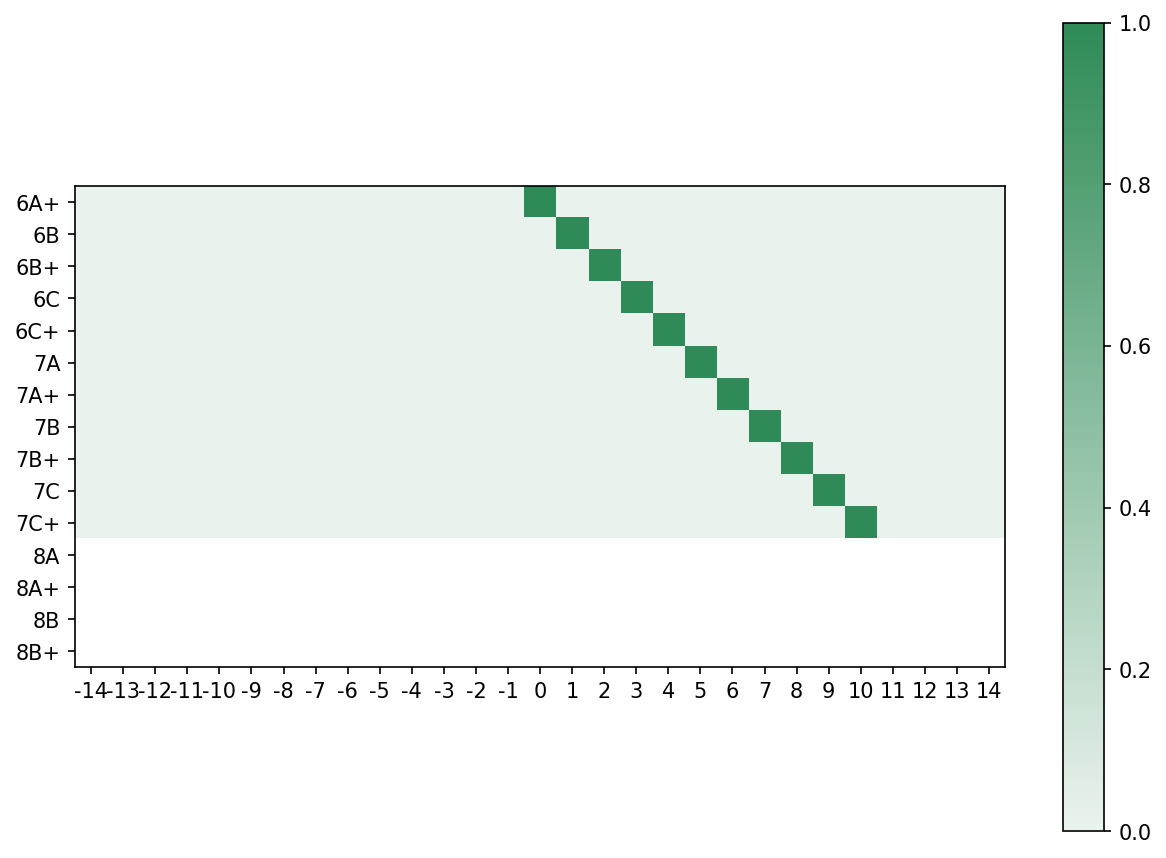

MAE = 2.1566383838653564
Correctness Count = {0} : [33.42%] + {1} : [13.11%] = 46.53%
First Bound Grade Error Count = {2} : [15.27%] + {3} : [13.02%] = 28.29%
Second Bound Grade Error Count = {4} : [10.24%] + {5} : [4.94%] + {6} : [5.13%] = 20.31%


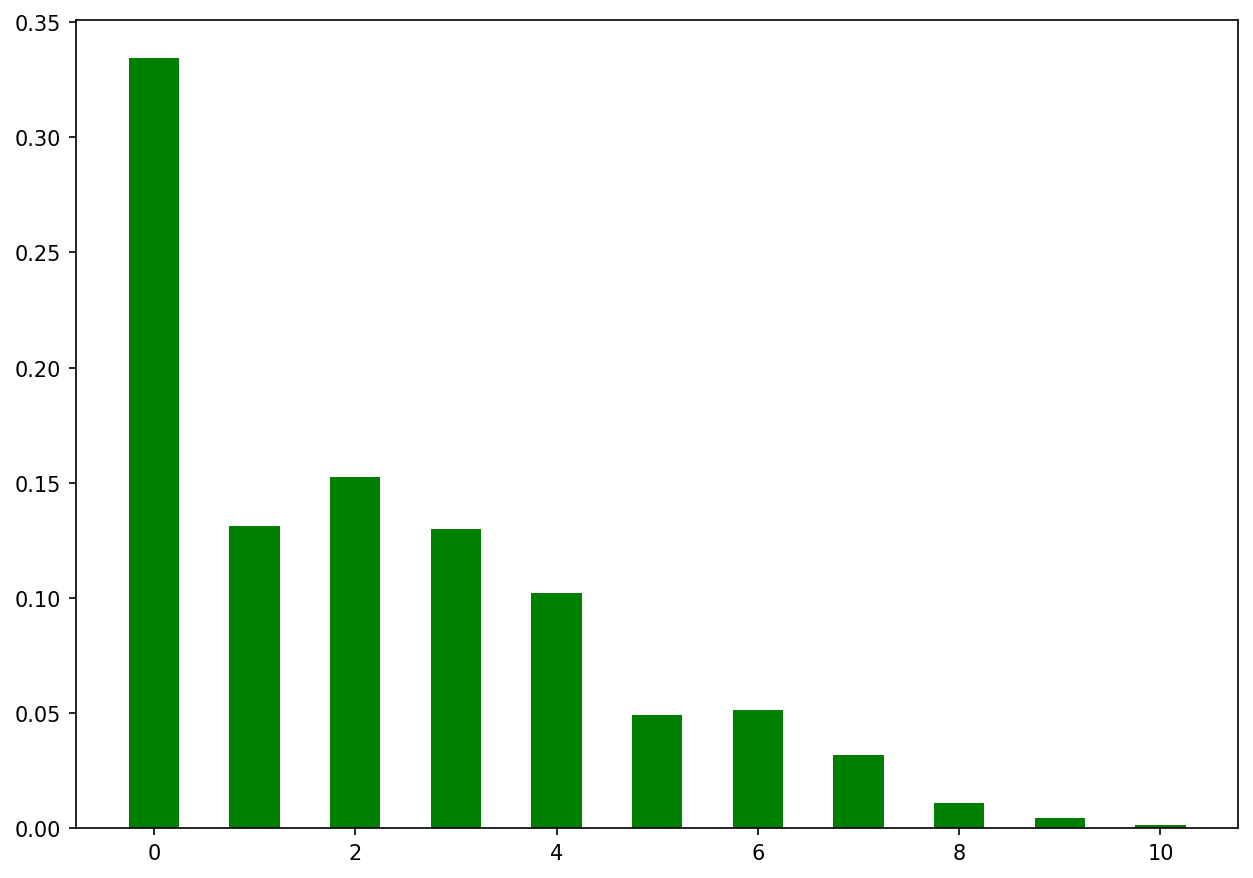

In [11]:
evaluate(model=model,
         call_model=call_model,
         dataloader=eval_dataloader,
         device=DEVICE)